In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [5]:
from image_utils import show_single_image, show_multiple_images
from experiments.imagenet_utils import denormalize

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Set environment

In [7]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load `ImageNet` dataset

In [8]:
from imagenet.dataloader import get_imagenet_dls

In [9]:
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)

In [10]:
len(train_loader), len(val_loader)

(543, 62)

In [11]:
ds_val = val_loader.dataset

In [12]:
# check out a sample
index = 0
sample = ds_val[index]

In [13]:
sample["ims"].shape, sample["ims"].min(), sample["ims"].max(), sample["labels"]

(torch.Size([3, 224, 224]), tensor(-2.0837), tensor(2.6400), tensor(0))

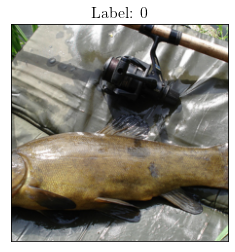

In [14]:
show_single_image(sample["ims"], title=f"Label: {sample['labels'].data}")

### Load model

In [15]:
from imagenet.models.classifier_ensemble import InvariantEnsemble

In [16]:
model = InvariantEnsemble("resnet50", pretrained=True)

In [17]:
# load weights from a checkpoint
ckpt_path = "imagenet/experiments/classifier_2022_01_19_15_36_sample_run/model_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt_state_dict = ckpt["state_dict"]
ckpt_state_dict = {k.replace("module.", ""):v for k, v in ckpt_state_dict.items()}

In [18]:
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [19]:
model = model.eval()

### Define individual models and ensembled model

In [20]:
class IMModel(torch.nn.Module):

    def __init__(self, base_model, mode):
        super(IMModel, self).__init__()

        self.base_model = base_model
        self.mode = mode
        self.mechanism = f"m_{mode}"
    
    def forward(self, x):
        x = self.base_model.backbone(x)
        x = getattr(self.base_model, self.mechanism)(x)
        return x

In [21]:
class AverageEnsembleModel(torch.nn.Module):

    def __init__(self, base_model):
        super(AverageEnsembleModel, self).__init__()

        self.base_model = base_model
    
    def forward(self, x):
        x = self.base_model.backbone(x)
        x_shape = self.base_model.m_shape(x)
        x_texture = self.base_model.m_texture(x)
        x_bg = self.base_model.m_bg(x)
        x = (x_shape + x_texture + x_bg) / 3.0
        return x

In [22]:
head = "shape"

if head == "average":
    clf_model = AverageEnsembleModel(base_model=model)
elif head in ["shape", "texture", "bg"]:
    clf_model = IMModel(base_model=model, mode=head)
else:
    raise ValueError

### Apply GradCAM on a sample image

In [23]:
# define the target layer to be used
# target_layer = model.m_shape[1]
# target_layer = shape_model.base_model.m_shape[1]

target_layer = clf_model.base_model.backbone[7][2].conv1
gradcam = GradCAM(clf_model, target_layer)

alpha = 0.7

In [24]:
# get image
sample = ds_val[index]
image, label = sample["ims"], sample["labels"]

# get gradcam mask
gc_mask, _ = gradcam(image.unsqueeze(0))
heatmap, result = visualize_cam(gc_mask, image)
gc_mask = gc_mask.squeeze(0)

# compute custom result: alpha-linear combination of image (denormalized) and heatmap
denormalized_image = denormalize(image.data.cpu())
overlap = alpha * denormalized_image + (1 - alpha) * heatmap.data.cpu()

# create a grid with original, heatmap and overlapped
grid = make_grid([denormalized_image, heatmap, overlap], nrow=3)

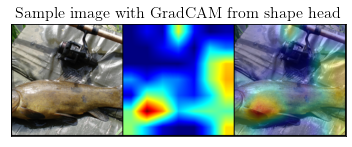

In [25]:
show_single_image(grid, normalized=False, title=f"Sample image with GradCAM from {head} head")

**Ideas**
1. What happens without CF data? (Need to train a new model)
2. ~What do each of the different heads focus on? Also, see what each head predicts? Relate that to the heatmap~.
3. How do the heatmaps look using CF data?
4. For a correct ensembled prediction, which of the three heads supplies *right* information? For an incorrect prediction, which of the three heads provide *wrong* information?

### Visualize heatmap for each head together

In [26]:
class EnsembleGradCAM:
    """Extension of GradCAM class for our use-case."""

    def __init__(self, ensemble_model, alpha=0.7, target_layer=None):
        super(EnsembleGradCAM, self).__init__()

        self.alpha = alpha
        
        self.m_shape = IMModel(base_model=ensemble_model, mode="shape")
        self.gradcam_shape = GradCAM(self.m_shape, self.m_shape.base_model.backbone[7][2].conv1)
        
        self.m_texture = IMModel(base_model=ensemble_model, mode="texture")
        self.gradcam_texture = GradCAM(self.m_texture, self.m_texture.base_model.backbone[7][2].conv1)

        self.m_bg = IMModel(base_model=ensemble_model, mode="bg")
        self.gradcam_bg = GradCAM(self.m_bg, self.m_bg.base_model.backbone[7][2].conv1)
        
        self.m_avg = AverageEnsembleModel(base_model=ensemble_model)
        self.gradcam_avg = GradCAM(self.m_avg, self.m_avg.base_model.backbone[7][2].conv1)
    
    def apply_single_gradcam_module(self, image, gradcam_module, prefix):

        image = image.clone()

        # get gradcam mask
        gc_mask, _ = gradcam_module(image.unsqueeze(0))
        heatmap, result = visualize_cam(gc_mask, image)
        gc_mask = gc_mask.squeeze(0)

        # compute custom result: alpha-linear combination of image (denormalized) and heatmap
        denormalized_image = denormalize(image.data.cpu())
        overlap = self.alpha * denormalized_image + (1 - self.alpha) * heatmap.data.cpu()

        # create a grid with original, heatmap and overlapped
        grid_original_heatmap_overlap = make_grid([denormalized_image, heatmap, overlap], nrow=3)
        
        output = {
            "image": denormalized_image,
            f"{prefix}_heatmap": heatmap,
            f"{prefix}_overlap": overlap,
            f"{prefix}_grid_original_heatmap_overlap": grid_original_heatmap_overlap,
        }
        return output

    def apply(self, image: torch.tensor, label: torch.tensor):
        assert len(image.shape) == 3, "Works on a single-image only."
        assert image.shape[0] == 3

        outputs = dict()
        
        mechanisms = ["shape", "texture", "bg", "avg"]
        for i, prefix in enumerate(mechanisms):
            gradcam_module = getattr(self, f"gradcam_{prefix}")
            output = self.apply_single_gradcam_module(image, gradcam_module, prefix)
            outputs.update(output)

        outputs["gt_label"] = label.item()
        for i, prefix in enumerate(mechanisms):
            outputs[f"{prefix}_label"] = getattr(self, f"m_{prefix}")(image.unsqueeze(0)).argmax(1)[0].cpu().item()

        return outputs

In [27]:
ensemble_gradcam = EnsembleGradCAM(ensemble_model=model)

In [28]:
# get image
index = 0
sample = ds_val[index]
image, label = sample["ims"], sample["labels"]

outputs = ensemble_gradcam.apply(image, label)

Customized plot with all info

In [29]:
with open("imagenet/data/in-mini/metadata.txt") as f:
    data = f.readlines()

assert len(data) == 1000
data = {x.split(" ")[0]:x.split(" ")[2].split("\n")[0] for x in data}
data = {k:v.replace("_", " ") for k, v in data.items()}
assert len(data) == 1000

In [30]:
def label_to_class_name(label: int, classes):
    return data[classes[label]]

In [31]:
images = [
    outputs["image"],
    outputs["shape_overlap"],
    outputs["texture_overlap"],
    outputs["bg_overlap"],
    outputs["avg_overlap"],
]

In [32]:
subtitles = [
    f"Original ($y = {label_to_class_name(outputs['gt_label'], ds_val.classes)}$)",
    "Shape ($\hat y = {}$)".format(label_to_class_name(outputs["shape_label"], ds_val.classes)),
    "Texture ($\hat y = {}$)".format(label_to_class_name(outputs["texture_label"], ds_val.classes)),
    "Background ($\hat y = {}$)".format(label_to_class_name(outputs["bg_label"], ds_val.classes)),
    "Average ($\hat y = {}$)".format(label_to_class_name(outputs["avg_label"], ds_val.classes)),
]

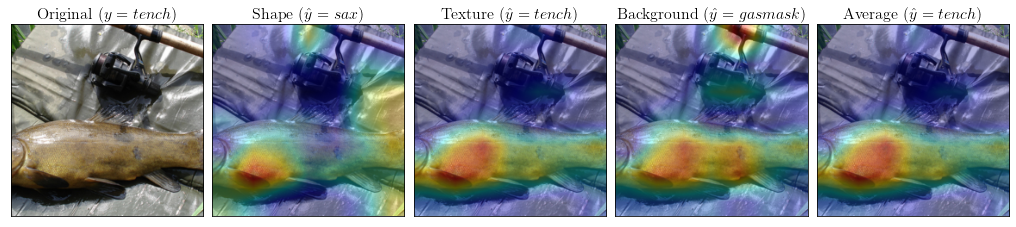

In [33]:
show_multiple_images(
    images,
    subtitles=subtitles,
    n_cols=5,
    normalized=False,
    figsize=(14, 4),
    title=None,
)

### Show results for many samples

In [34]:
def display_result_for_sample(dataset, index, image=None, label=None, save=True, path="sample_gradcam_label_{}_index_{}.pdf"):

    # get image
    if image is None and label is None:
        sample = dataset[index]
        image, label = sample["ims"], sample["labels"]
    
    # get gradcam outputs
    outputs = ensemble_gradcam.apply(image, label)
    
    images = [
        outputs["image"],
        outputs["shape_overlap"],
        outputs["texture_overlap"],
        outputs["bg_overlap"],
        outputs["avg_overlap"],
    ]
    true_class_label = label_to_class_name(outputs['gt_label'], dataset.classes)
    subtitles = [
        f"Original ($y = {true_class_label}$)",
        "Shape ($\hat y = {}$)".format(label_to_class_name(outputs["shape_label"], dataset.classes)),
        "Texture ($\hat y = {}$)".format(label_to_class_name(outputs["texture_label"], dataset.classes)),
        "Background ($\hat y = {}$)".format(label_to_class_name(outputs["bg_label"], dataset.classes)),
        "Average ($\hat y = {}$)".format(label_to_class_name(outputs["avg_label"], ds_val.classes)),
    ]

    path = path.format(true_class_label, index)
    path = join(REPO_PATH, "experiments", "results", "plots", path)

    show_multiple_images(
        images,
        subtitles=subtitles,
        n_cols=len(images),
        normalized=False,
        figsize=(14, 4),
        title=None,
        save=save,
        path=path,
    )

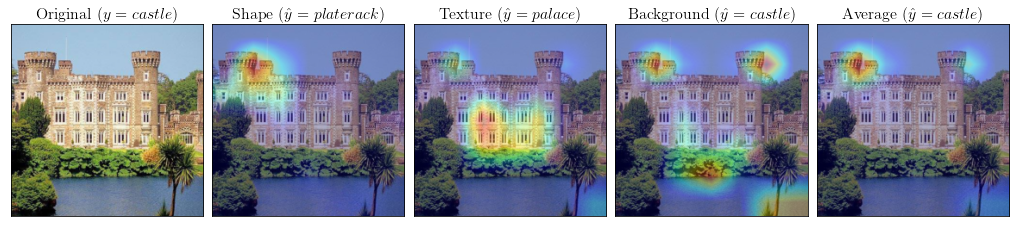

In [37]:
display_result_for_sample(dataset=ds_val, index=1871, save=True)

2732


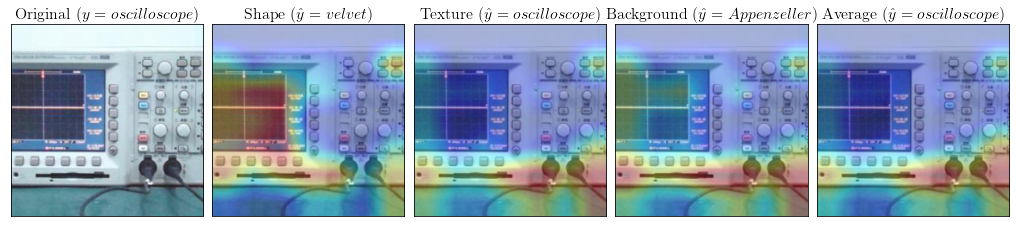

In [36]:
indices = np.random.choice(range(len(ds_val)), 1)

for i in indices:
    print(i)
    display_result_for_sample(dataset=ds_val, index=i, save=True)

### Test on counterfactual samples

In [37]:
# Read the ImageNet categories
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    imagenet_categories = [s.strip() for s in f.readlines()]

--2022-01-22 22:03:52--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.3’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.002s  

2022-01-22 22:03:52 (4.92 MB/s) - ‘imagenet_classes.txt.3’ saved [10472/10472]



In [38]:
from cgn_framework.imagenet.models import CGN
from cgn_framework.imagenet.generate_data import sample_classes

cgn = CGN(batch_sz=1, pretrained=False)

# load weights and push to GPU
weights = torch.load(join(REPO_PATH, 'cgn_framework/imagenet/weights/cgn.pth'), map_location='cpu')
cgn.load_state_dict(weights)
cgn.eval().to(device);

In [78]:
# Get the input classes
ys = sample_classes('best_classes')
# ys = [898, 954, 460]
# ys = [780, 275, 50]
# ys = [907, 959, 888]

print(f"     Shape: {imagenet_categories[ys[0]]} (id: {ys[0]})")
print(f"Foreground: {imagenet_categories[ys[1]]} (id: {ys[1]})")
print(f"Background: {imagenet_categories[ys[2]]} (id: {ys[2]})")

     Shape: toaster (id: 859)
Foreground: corn (id: 987)
Background: snorkel (id: 801)


In [79]:
# Generate the output
with torch.no_grad():
    x_gt, mask, premask, foreground, background, bg_mask = cgn(ys=ys)
    x_gen = mask * foreground + (1 - mask) * background

In [80]:
image = x_gen[0]
pil_image = transforms.ToPILImage()((image + 1) * 0.5)
transformed_image = ds_val.T_ims(pil_image)

In [81]:
transformed_image.min(), transformed_image.max(), transformed_image.shape

(tensor(-2.0323), tensor(2.2318), torch.Size([3, 224, 224]))

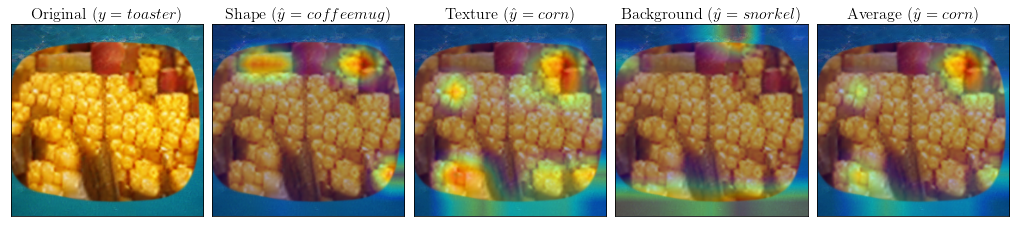

In [82]:
display_result_for_sample(image=transformed_image, label=torch.tensor(ys[0]), dataset=ds_val, index=None)

Interesting cases:
1. [780, 275, 50]
2. [907, 959, 888]
3. [833, 438, 354]
4. [859, 987, 801]

### Plot results for *interesting* cases

In [37]:
# collect all predictions to find correct predictions and misprediction

iterator = tqdm(
    enumerate(val_loader),
    desc="Evaluating on validation set",
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
)

y_shape_all = []
y_texture_all = []
y_bg_all = []
y_gt_all = []
y_avg_all = []

with torch.no_grad():
    for i, batch in iterator:
        
        if i == 10 + 1:
            break

        ims = batch["ims"].to(device)
        labels = batch["labels"].to(device)

        out = model(ims)

        y_shape = out["shape_preds"].argmax(1)
        y_texture = out["texture_preds"].argmax(1)
        y_bg = out["bg_preds"].argmax(1)
        y_avg = out["avg_preds"].argmax(1)
        
        y_shape_all.append(y_shape.data.cpu())
        y_texture_all.append(y_texture.data.cpu())
        y_bg_all.append(y_bg.data.cpu())
        y_gt_all.append(labels.data.cpu())
        y_avg_all.append(y_avg.data.cpu())

Evaluating on validation set: |          | 11/? [03:17<00:00, 17.97s/it]                                          


In [38]:
df = pd.DataFrame(None, columns=["y_gt", "y_shape", "y_texture", "y_bg", "y_avg"])

for col in df.columns:
    df[col] = torch.cat(eval(f"{col}_all")).numpy()

In [39]:
df

,y_gt,y_shape,y_texture,y_bg,y_avg
0,0,776,0,570,0
1,0,700,0,263,0
2,0,734,0,0,0
3,1,19,1,1,1
4,1,123,647,122,122
...,...,...,...,...,...
699,201,203,201,157,201
700,201,585,201,674,201
701,201,201,201,180,201
702,201,203,201,703,201


### Notes

1. Interesting indices to look at qualitative results:
    1. 40 (goldfinch)
    2. 2825 (perfume)
    3. 2958 (puck)
    4. 797
    5. 1871
    6. 976
    7. 2607